# Contents of this notebook
The aim of this notebook is to show my understanding of Workflows and FAIR principles, which was introduced in the first lecture of BERN02.

This notebook contains one part of my previous weekly assignment. A part of this assignment is to complete the example code given by the course page.

In the notebook it shows the process of solving the shallow water equation, with a fixed wall at the right hand side and an inflow boundary at the left. The result is tested for the Riemann problem with a jump from 2 down to 1.


Here is a brief theoretical introduction of the problem.



## Brief introduction
Here in the question the shallow water equation in 1D is in the form $$\mathbf{u}_t+\mathbf{f}(\mathbf{u})_x=\mathbf{0},$$ with $\mathbf{u}=(h,hv)^{T}$ and $$\mathbf{f}(\mathbf{u})=
\left(
  \begin{array}{c}
  hv \\
  hv^2+\frac{1}{2}gh^2
  \end{array}
  \right).
$$
In this fraction of the assignment, the length of the region is 4. $g=1$. More details will be introduced among the code cells.

## Installation of the packages
The requirement of packages are given in the repository (environment.txt).

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

Then try to install dune:

In [2]:
!pip install dune-grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached dune_geometry-2.10.0-cp312-cp312-linux_x86_64.whl
  Using cached dune_common-2.10.0-cp312-cp312-linux_x86_64.whl
  Using cached portalocker-3.2.0-py3-none-any.whl.metadata (8.7 kB)
Using cached portalocker-3.2.0-py3-none-any.whl (22 kB)
  Created wheel for dune-grid: filename=dune_grid-2.10.0-cp312-cp312-linux_x86_64.whl size=1521566 sha256=3ee258a4bfcef976f0b7c1db3db5c03b454da7f8dbc4a9567abd3aa30f13b4ca
  Stored in directory: /root/.cache/pip/wheels/17/78/18/5d8a373e38c1030d1b4c6c358e44653f92b09946ecfb12fa88
Successfully built dune-grid


In [3]:
!pip install mpi4py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.3 MB/s eta 0:00:00


After this we import

In [4]:
from dune.grid import cartesianDomain, gridFunction, GridFunction, CommOp

Then it is necessary to define some functions. In the beginning is the plot function.
## Definitions of needed functions
Only 1D is needed for this context. Here the example codes from my course page have been modified for this reason.

In [8]:
def plot(view, mapper, U):
  if view.dimension == 1:
    x = np.zeros(shape=(len(mapper)))
    h = np.zeros(shape=(len(mapper)))
    u = np.zeros(shape=(len(mapper)))

    for e in view.elements:
      idx = mapper.index(e)
      x[idx] = e.geometry.center[0]
      h[idx] = U[idx][0]
      u[idx] = U[idx][1]/h[idx]
    plt.plot(x,h,color='red',label='water height')
    plt.plot(x,u,color='blue',label='velocity')
    plt.legend()
    plt.show()
  else:
    assert "dimension not supported"

The shallow water function also need to be defined.

At the edge of each cell, the local Lax-Friedrich flux is used.

In [10]:
def ShallowWater(g = 1., dim = 1 ):
 dim = dim
 dimRange = dim+1
 class Model:
  # compute velocity
  def velocity(U):
    return np.array([U[1]/U[0]])
 # analytical flux
  def F_c(t,x,U):
 # compute primitive variables
    h, v = U[0], Model.velocity(U)
    p = 0.5*g*h*h
 # shallow water analytical flux
    flux = np.vstack([ h*v, h * np.outer(v,v) + p * np.eye(dim)])
    return flux
 # return lambda for Lax-Friedrichs
  def maxWaveSpeed(t,x,U,n):
    h,v = U[0], Model.velocity(U)
    return abs(np.dot(v,n)) + np.sqrt(g*h)
 # numerical flux (Local Lax-Friedrichs), returns flux and dtEstimate
  def NumericalF_c(t, x, n, uL, uR ):
    flux = Model.F_c(t, x, uL) @ n # F_c(uL) * n
    flux += Model.F_c(t, x, uR) @ n # F_c(uR) * n
    ws = max(Model.maxWaveSpeed( t, x, uL, n ), Model.maxWaveSpeed( t, x, uR, n ))
    diff = uL- uR
    flux += ws*diff
    flux *= 0.5
    return flux,ws
 return Model

In [14]:
def initialize(view, mapper, u0):
  U = np.zeros(shape=(len(mapper), view.dimension+1))
  #assign cell values by evaluation the given function at the cell center
  for e in view.elements:
    U[mapper.index(e)]=u0(e.geometry.center)
  return U

Time evolving, according to the requirement, is realized by "using the explicit Euler method with constant mesh width $\Delta t$ in time". The boundary condition is also included in this function. As the assignment said, on the LHS there is always an input. On the RHS there is a "fixed wall", which means the velocity goes backward instantly with the same strength.

In [11]:
def evolve(t, model, view, mapper, U): # time move on
    from dune.grid import PartitionType
    # create update vector
    upd = np.zeros(shape=U.shape)

    # initialize dt with something big
    dt = 1e100

    # iterate over all cells
    for cell in view.elements:

        volume = cell.geometry.volume
        idxInside = mapper.index( cell )
        sumfactor = 0.0

        # loop of all intersections (points in 1d, edges in 2d, faces in 3d)
        for isec in view.intersections( cell ):
            volfactor = isec.geometry.volume / volume
            xLocal    = isec.geometry.center
            unitOuterNormal = isec.centerUnitOuterNormal

            # if neighboring element is available
            if isec.outside is not None:
                idxOutside = mapper.index(isec.outside)
                # one sided flux evaluation
                if idxInside < idxOutside:
                    # compute numerical flux, wave speed
                    flux,ws = model.NumericalF_c(t, xLocal, unitOuterNormal, U[idxInside], U[idxOutside] )

                    flux *= volfactor
                    sumfactor += ws*volfactor

                    # use conservation property
                    upd[idxInside]  -= flux
                    upd[idxOutside] += flux

            # if domain boundary
            elif isec.boundary:
                x = xLocal[0]
                n = unitOuterNormal

                if abs(x-0.0)<1e-10 and n[0]<0:
                    h_in, v_in = 2.0,2.0 # which can be also changed into time dependent BC
                    uR = np.array([h_in, h_in*v_in])
                    #CREATE uR for the function to compute
                    #numerical flux
                elif abs(x-4.0)<1e-10 and n[0]>0:
                    h, hv = U[idxInside]
                    uR = np.array([h, -hv]) # inversed velocity dir
                    # fixed wall, wave hit back

                flux,ws = model.NumericalF_c(t, xLocal, unitOuterNormal, U[idxInside],  uR)
                # This is to create a ghost RHS
                # By default example RHS is set as a same value as the inside
                flux *= volfactor

                upd[idxInside] -= flux
                sumfactor += ws*volfactor

        if sumfactor > 0:
            dt = min(dt, 1.0 / sumfactor)

    # for parallel runs synchronize upd vector on ghost cells
    mapper.communicate(view.interiorBorderPartition, view.allPartition, CommOp.set, upd)

    # synchronize dt over all processes
    dt = view.comm.min( dt )

    # Explicit Euler time stepping
    U += dt*upd

    return dt

After these preparation we can do the computing, in this function the plot is automatically called. We can therefore see the result right after computation.

In [12]:
def compute(view, name):
    from dune.common import FieldVector
    @gridFunction(view)
    def u0(x): # is is a FieldVector
       #inside = (x*x) < 0.25 #sample
       #return  [1.0 if inside else 0.5] + [ 0 for d in range(view.dimension)] #sample
       h = 2.0 if x[0]<2.0 else 1.0
       v = 2.0 if x[0]<2.0 else 1.0#[0] is to evade error by
       #vector<int
       return [h, h*v]


    # create shallow water model
    model = ShallowWater(g=1., dim=view.dimension)

    # create a mapper to assign indices to elements
    # in order to attach data to grid cells
    mapper = view.mapper(lambda gt: gt.dim == view.dimension)

    # initialize solution with initial data
    U = initialize(view, mapper, u0)

    t = 0.0
    T = 0.5
    savestep = 0.01
    savetime = savestep

    start = time.time()
    while t < T:
        # evolve to next time step
        dt = evolve(t, model, view, mapper, U)
        t += dt
        if t > savetime:
            if view.comm.rank == 0:
                print(f"Time = {t}, dt = {dt}")
            savetime += savestep

    # plot solution
    plot(view, mapper, U)

    end = time.time()
    print("time used (Python):", end-start)
    print(f"[FINISHED] Final time T = {t:.5f}")

## Results of the code
In this section the code to activate computing, and also, the corresponding result, are shown.


Time = 0.010983495705504467, dt = 0.003661165235168156
Time = 0.021966991411008937, dt = 0.003661165235168156
Time = 0.032950487116513404, dt = 0.003661165235168156
Time = 0.04027281758684972, dt = 0.003661165235168156
Time = 0.05125631329235419, dt = 0.003661165235168156
Time = 0.06223980899785866, dt = 0.003661165235168156
Time = 0.07322330470336312, dt = 0.003661165235168156
Time = 0.08054563517369943, dt = 0.003661165235168156
Time = 0.0915291308792039, dt = 0.003661165235168156
Time = 0.10251262658470837, dt = 0.003661165235168156
Time = 0.11349612229021284, dt = 0.003661165235168156
Time = 0.12081845276054916, dt = 0.003661165235168156
Time = 0.13180194846605361, dt = 0.003661165235168156
Time = 0.14278544417155808, dt = 0.003661165235168156
Time = 0.1501077746418944, dt = 0.003661165235168156
Time = 0.16109127034739887, dt = 0.003661165235168156
Time = 0.17207476605290334, dt = 0.003661165235168156
Time = 0.1830582617584078, dt = 0.003661165235168156
Time = 0.19038059222874412, 

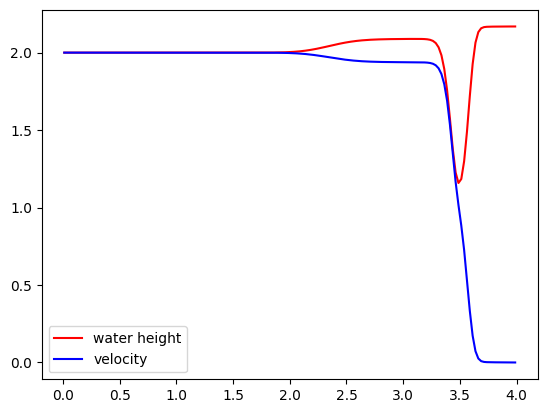

time used (Python): 3.4405975341796875
[FINISHED] Final time T = 0.50158


In [15]:
if __name__ == '__main__':

    name = "sw_yasp2d"

    dim = 1

    from dune.grid import yaspGrid as hierarchicGrid
    #from dune.alugrid import aluCubeGrid as hierarchicGrid
    domain = cartesianDomain([0]*dim, [4]*dim, [160]*dim)
    view = hierarchicGrid(domain)
    compute(view,name)

In the image it shows the result at the time when our time evolving **just past** T, which is $T=0.5$ in this example. The figure above is actually the numerical solution at $T=0.50158$.

By changing the parameter T at the function compute, for example from $T=0.1$ to $T=0.9$, we can generate a series of plots which shows the solution of the given problem as the time evolving. 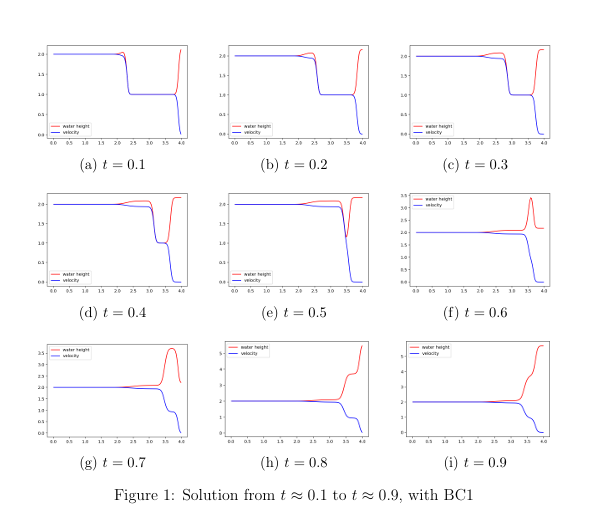. It looks like this figure, which comes from my report on that week.

# How this workflow relates to FAIR data principles?
The main topic of this notebook, again, is to discuss how to make the workflow relates to FAIR data principles. I want to share my idea here at this section.




## Findable
GitHub is a common platform where creators can store and share their work. Every user can search for this repository. By setting keywords, link the releases to certain papers, or/and link to author's DOI, it is possible to make the contents easier to be found.

However, this example here is only a part of my assignment last semester. So sadly there are no specific published paper I want to link to.




## Accessible
By setting the GitHub page public, the workflow should be technically accessible to readers. This is a famous and open, free platform to use. However, they might meet problems with making use of it since there might be risk using the contents without authorizing.

To solve this problem, a license should be assigned whenever the creator wants to share the contents. In this exercise CC0-1.0 license is chosen.

However, to do a sharing of a real serious workflow to all possible users, I need to get fully understanding of all possible licenses before I choose a specific license and publish my contents.



## Interoperable
The Jupyter notebook is a useful interoperable media to share contents for me. It provides another dimension of explaining codes besides comments. Also, Python is used in this project, which is a commonly used language that easy to read for human and machine. After making the workflow easier to read (by both  human and machine), the contents are more interoperable.

This project here has no data to be processed. However, to make the workflow interoperable, I should make sure that all datas should be stored in a more machine-friendly form, e.g. JSON or CSV, in the case that I am dealing with a project with data processing.


## Reusable

First of all, to make it easier to be reused, a usage license should be properly chosen and clearly mentioned. Otherwise, the problem I mentioned in the Accessible part would happen.

The environment requirement is mentioned in the GitHub repository page, which makes users know which version of packages were used when I finished the work. This makes the re-implementation possible.

# GitHub repository address
https://github.com/LW1308/Exercise-Workflows-and-FAIR-principles